get radius of giration from gustaf to see physical quantity about protein
look at fractions of secondary structures. not abosolute number present.

In [31]:
import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from scipy.spatial import distance
import py3Dmol
from DSSPparser import parseDSSP

In [32]:
CAMEO_PREDICTION_PATH = "../data/taccruns/predictions-cameo-model1ptm/"
CAMEO_PREDICTION_PATH_model4 = "../data/taccruns/predictions-cameo-model4ptm/"
CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP = "../data/taccruns/predictions-cameo-mod-s0-model1ptm/"
CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP_model4 = "../data/taccruns/predictions-cameo-mod-s0-model4ptm/"
CAMEO_PREDICTION_PATH_1ITER = "../data/taccruns/predictions-cameo-model1ptm-numiter_1/"
CAMEO_PREDICTION_PATH_1ITER_ZEROED_SINGLE_REP = "../data/taccruns/predictions-cameo-mod-s0-model1ptm-numiter_1/"

DSSP_PATH = "../data/taccruns/DSSP/"
FASTA_DIR = "../data/taccruns/fasta_dir/"

In [33]:
def tmscore(target, modified):
    tmscore = -1
    os.system(f"./../tmscore/TMscore {target} {modified} >> tmscore_temp_output")
    with open("tmscore_temp_output") as f:
        for line in f:
            if line.startswith("TM-score"):
                tmscore = float(line.split('=')[1].strip().split(' ')[0])
    os.system("rm tmscore_temp_output")
    return tmscore
def get_amino_acid_len(protien):
    with open(FASTA_DIR + protien + '.fasta') as f:
        fastafile = f.readlines()
    return(len(fastafile[1]))
def get_max_atom_distance(pth):
    max_dist = -1
    list_atom_locs = []
    with open(pth) as p:
        content = p.readlines()
    for line in content:
        if line.startswith("ATOM"):
            line = line.replace('-', ' -') # this is important for when two numbers are too close that there is not a space between
            list_atom_locs.append([float(line.split()[6]),float(line.split()[7]),float(line.split()[8])])
            if line.split()[9] != "1.00":
                print(pth)
                print('WARNING: ATOM LOCATION FAILED. SEE get_max_atom_distance')
    points = np.array(list_atom_locs)
    hull = ConvexHull(points)
    hullpoints = points[hull.vertices,:]
    hdist = cdist(hullpoints, hullpoints, metric='euclidean')
    bestpair = np.unravel_index(hdist.argmax(), hdist.shape)
    return distance.euclidean( hullpoints[bestpair[0]], hullpoints[bestpair[1]] )
def get_secondary_struc_data(pth):
    H = 0# H         Alpha helix (4-12)
    B = 0# B         Isolated beta-bridge residue
    E = 0# E         Strand
    G = 0# G         3-10 helix
    I = 0# I         Pi helix
    T = 0# T         Turn
    S = 0# S         Bend
    n = 0# -         None
    parser = parseDSSP(pth)
    parser.parse()
    pddict = parser.dictTodataframe()
    for line in pddict['struct']:
        if line.strip() == 'H': H+=1
        if line.strip() == 'B': B+=1
        if line.strip() == 'E': E+=1
        if line.strip() == 'G': G+=1
        if line.strip() == 'I': I+=1
        if line.strip() == 'T': T+=1
        if line.strip() == 'S': S+=1
        if line.strip() == '': n+=1
    return H, B, E, G, I, T, S, n
print(get_secondary_struc_data(DSSP_PATH + '6tf4_A_model_1_ptm_unrelaxed.pdb' + '.dssp'))
print(get_max_atom_distance(CAMEO_PREDICTION_PATH + '7tav_B_model_1_ptm_unrelaxed.pdb'))
print(tmscore(CAMEO_PREDICTION_PATH + '7tav_B_model_1_ptm_unrelaxed.pdb', CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP + '7tav_B_model_1_ptm_unrelaxed.pdb'))
print(get_amino_acid_len('7rdt_A'))

(8, 0, 30, 3, 0, 9, 5, 12)
70.40555799793083
0.9971
250


In [34]:
hmmstats_dict = {}
with open(CAMEO_PREDICTION_PATH + "hmmstat.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    hmmstats_dict[parsed[0]] = {}
    hmmstats_dict[parsed[0]]['n'] = float(parsed[4])
    hmmstats_dict[parsed[0]]['effn'] = float(parsed[5])
    hmmstats_dict[parsed[0]]['M'] = float(parsed[6])
    hmmstats_dict[parsed[0]]['relent'] = float(parsed[7])
    hmmstats_dict[parsed[0]]['info'] = float(parsed[8])
    hmmstats_dict[parsed[0]]['prelE'] = float(parsed[9])
    hmmstats_dict[parsed[0]]['compkl'] = float(parsed[10])
with open(CAMEO_PREDICTION_PATH + "MSV_from_hmmfile.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    hmmstats_dict[parsed[0]]['MSV1'] = float(parsed[4])
    hmmstats_dict[parsed[0]]['MSV2'] = float(parsed[5])
with open(CAMEO_PREDICTION_PATH + "VITERBI_from_hmmfile.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    hmmstats_dict[parsed[0]]['VITERBI1'] = float(parsed[4])
    hmmstats_dict[parsed[0]]['VITERBI2'] = float(parsed[5])
with open(CAMEO_PREDICTION_PATH + "FORWARD_from_hmmfile.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    hmmstats_dict[parsed[0]]['FORWARD1'] = float(parsed[4])
    hmmstats_dict[parsed[0]]['FORWARD2'] = float(parsed[5])
hmmvals = ['n','effn','M','relent','info','prelE','compkl','MSV1','MSV2','VITERBI1','VITERBI2','FORWARD1','FORWARD2']

In [55]:
cameo_dict = {}
for pdb_file in os.listdir(CAMEO_PREDICTION_PATH): #for each predicted structure
    if pdb_file[-1] == "b": #check if is a pdb file
        if pdb_file[19:26] == 'unrelax': #check if it the unrelaxed prediction
            protein = pdb_file[0:6]
            cameo_dict[protein] = {}
            cameo_dict[protein]['tmscore_model1'] = tmscore(CAMEO_PREDICTION_PATH + pdb_file, CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP + pdb_file)
            cameo_dict[protein]['tmscore_model4'] = tmscore(CAMEO_PREDICTION_PATH_model4 + pdb_file[0:6]+"_model_4_ptm_unrelaxed.pdb", CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP_model4 + pdb_file[0:6]+"_model_4_ptm_unrelaxed.pdb")
            cameo_dict[protein]['tmscore_model1_1iter'] = tmscore(CAMEO_PREDICTION_PATH_1ITER + pdb_file, CAMEO_PREDICTION_PATH_1ITER_ZEROED_SINGLE_REP + pdb_file)
            for stat in hmmvals:
                cameo_dict[protein][stat] = hmmstats_dict[protein][stat]
            cameo_dict[protein]['seqlen'] = get_amino_acid_len(protein)
            cameo_dict[protein]['folded_size'] = get_max_atom_distance(CAMEO_PREDICTION_PATH + pdb_file)
            cameo_dict[protein]['compactness'] = cameo_dict[protein]['folded_size']/cameo_dict[protein]['seqlen']
            
            Alphahelix412, Isolatedbetabridgeresidue, Strand, helix310, Pihelix, Turn, Bend, no_code = get_secondary_struc_data(DSSP_PATH + pdb_file + '.dssp')
            cameo_dict[protein]['residue_count_Alphahelix412'] = Alphahelix412
            cameo_dict[protein]['residue_count_Isolatedbetabridgeresidue'] = Isolatedbetabridgeresidue
            cameo_dict[protein]['residue_count_Strand'] = Strand
            cameo_dict[protein]['residue_count_helix310'] = helix310
            cameo_dict[protein]['residue_count_Pihelix'] = Pihelix
            cameo_dict[protein]['residue_count_Turn'] = Turn
            cameo_dict[protein]['residue_count_Bend'] = Bend
            cameo_dict[protein]['residue_count_no_code'] = no_code
            cameo_dict[protein]['residue_count_helix'] = Alphahelix412 + helix310
            cameo_dict[protein]['residue_count_coil'] = no_code + Pihelix + Turn + Bend
            cameo_dict[protein]['residue_count_extended'] = Isolatedbetabridgeresidue + Strand

            total_num_secondary_struct = Alphahelix412 + Isolatedbetabridgeresidue + Strand + helix310 + Pihelix + Turn + Bend + no_code
            cameo_dict[protein]['residue_count_Alphahelix412_fraction'] = Alphahelix412 / total_num_secondary_struct
            cameo_dict[protein]['residue_count_Isolatedbetabridgeresidue_fraction'] = Isolatedbetabridgeresidue / total_num_secondary_struct
            cameo_dict[protein]['residue_count_Strand_fraction'] = Strand / total_num_secondary_struct
            cameo_dict[protein]['residue_count_helix310_fraction'] = helix310 / total_num_secondary_struct
            cameo_dict[protein]['residue_count_Pihelix_fraction'] = Pihelix / total_num_secondary_struct
            cameo_dict[protein]['residue_count_Turn_fraction'] = Turn / total_num_secondary_struct
            cameo_dict[protein]['residue_count_Bend_fraction'] = Bend / total_num_secondary_struct
            cameo_dict[protein]['residue_count_no_code_fraction'] = no_code / total_num_secondary_struct
            cameo_dict[protein]['residue_count_helix_fraction'] = Alphahelix412 + helix310 / total_num_secondary_struct
            cameo_dict[protein]['residue_count_coil_fraction'] = no_code + Pihelix + Turn + Bend / total_num_secondary_struct
            cameo_dict[protein]['residue_count_extended_fraction'] = Isolatedbetabridgeresidue + Strand / total_num_secondary_struct

stats = list(cameo_dict['6tf4_A'].keys())
for stat in list(stats):
    if stat[0:7] == 'tmscore':
        stats.remove(stat)


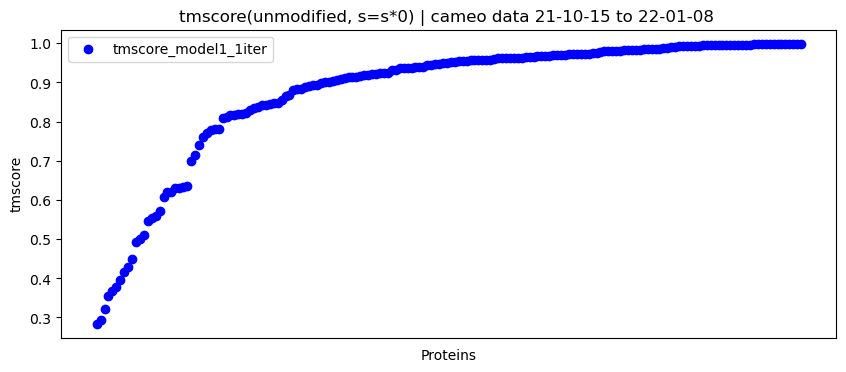

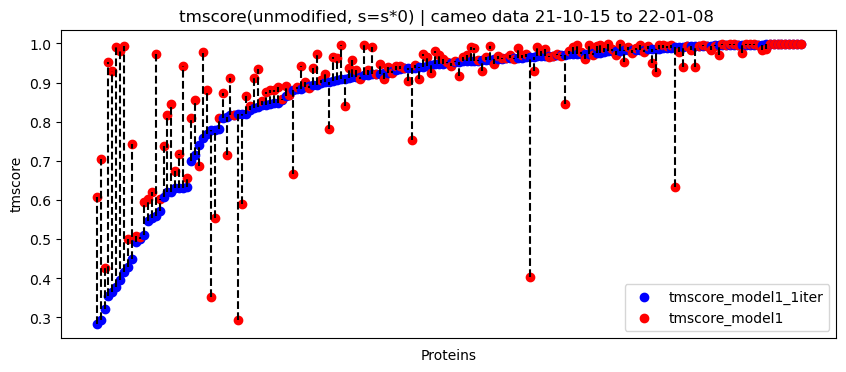

tmscore_model1_1iter generated proteins TMScore is greater: 31.11% (56/180)


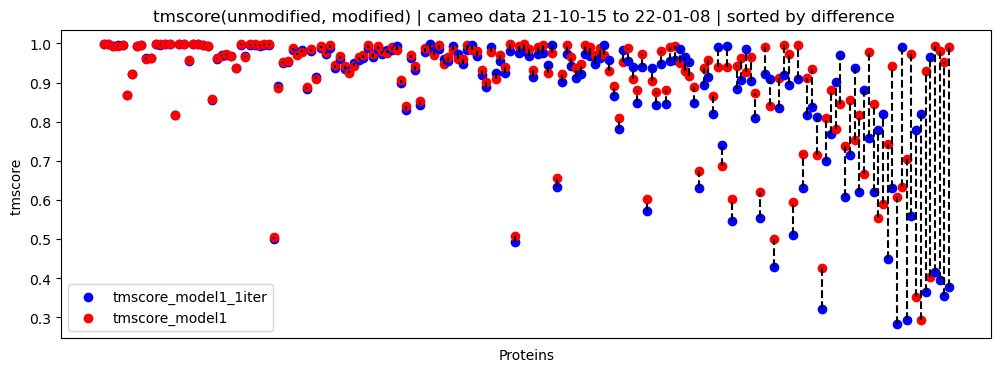

In [56]:
main_run = 'tmscore_model1_1iter'
compare_run = 'tmscore_model1'

####
# get list of protein names in the order of tmscore differences
protein_tmscore_dict = {}
for protein in cameo_dict.keys():
    protein_tmscore_dict[protein] = cameo_dict[protein][main_run]
sorted_protein_tmscore_dict = {}
for w in sorted(protein_tmscore_dict, key=protein_tmscore_dict.get):
    sorted_protein_tmscore_dict[w] = protein_tmscore_dict[w]

#######

plt.rcParams['figure.figsize'] = [10, 4]
first_iter = True
for protein in sorted_protein_tmscore_dict:
    #plt.scatter(protein, cameo_dict[protein]['tmscore'], label='model 1' if first_iter else '', color='blue')
    plt.scatter(protein, cameo_dict[protein][main_run], label=main_run if first_iter else '', color='blue')
    first_iter = False
#plt.legend()
plt.ylabel('tmscore')
plt.title('tmscore(unmodified, s=s*0) | cameo data 21-10-15 to 22-01-08 ')
plt.xticks(rotation=90)
plt.xticks([])
plt.xlabel('Proteins')
plt.legend()
plt.show()


####

plt.rcParams['figure.figsize'] = [10, 4]
first_iter = True
for protein in sorted_protein_tmscore_dict:
    plt.scatter(protein, cameo_dict[protein][main_run], color='blue', label=main_run if first_iter else '')
    plt.scatter(protein, cameo_dict[protein][compare_run], color='red', label=compare_run if first_iter else '')
    plt.vlines(protein, ymin = min([cameo_dict[protein][main_run],cameo_dict[protein][compare_run]]), ymax = max([cameo_dict[protein][main_run],cameo_dict[protein][compare_run]]), colors = 'black', linestyle='dashed')
    first_iter = False
plt.legend()
plt.ylabel('tmscore')
plt.title('tmscore(unmodified, s=s*0) | cameo data 21-10-15 to 22-01-08 ')
plt.xticks(rotation=90)
plt.xticks([])
plt.xlabel('Proteins')
plt.show()


###


# get list of protein names in the order of tmscore differences
num_model1_greater = 0 # count instances of model 1 generated proteins having a higher TMscore
t = 0
protein_diff_dict = {}
for protein in cameo_dict.keys():
    protein_diff_dict[protein] = abs(cameo_dict[protein][compare_run] - cameo_dict[protein][main_run])
    if cameo_dict[protein][main_run] > cameo_dict[protein][compare_run]: num_model1_greater +=1
    t += 1
sorted_protein_diff_dict = {}
for w in sorted(protein_diff_dict, key=protein_diff_dict.get):
    sorted_protein_diff_dict[w] = protein_diff_dict[w]
print('{} generated proteins TMScore is greater: {:0.4}% ({}/{})'.format(main_run, (num_model1_greater/t)*100 , num_model1_greater,t))


##

first_iter = True
plt.rcParams['figure.figsize'] = [12, 4]
for protein in sorted_protein_diff_dict:
    plt.scatter(protein, cameo_dict[protein][main_run], color='blue', label=main_run if first_iter else '')
    plt.scatter(protein, cameo_dict[protein][compare_run], color='red', label=compare_run if first_iter else '')
    first_iter = False
    plt.vlines(protein, ymin = min([cameo_dict[protein][main_run],cameo_dict[protein][compare_run]]), ymax = max([cameo_dict[protein][main_run],cameo_dict[protein][compare_run]]), colors = 'black', linestyle='dashed')
plt.legend()
plt.ylabel('tmscore ')
plt.title('tmscore(unmodified, modified) | cameo data 21-10-15 to 22-01-08 | sorted by difference ')#| model 1 > model 4 {:0.4} %'.format((num_model1_greater/t)*100))
#plt.xticks(rotation=90)
plt.xticks([])
plt.xlabel('Proteins')
plt.show()

In [59]:
m = 'tmscore_model1'# tmscore_model4 tmscore_model1_1iter
print('possible effects coming from alignment (HMMSTATS), from size (folded size and sequence len), and secondary structures (DSSP) \n')
print('** {} vs details **'.format(m))
exclude = []#['7kdx_B'] # this outlier has an effn=60
list_stats_r2 = {}
for stat in stats:
    x=[]
    y=[]
    for protein in cameo_dict.keys():
        if not protein in exclude:
            x.append(cameo_dict[protein][stat])
            y.append(cameo_dict[protein][m])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    list_stats_r2[stat] = r_value**2

for w in sorted(list_stats_r2, key=list_stats_r2.get, reverse=True):
    print(w, list_stats_r2[w])

possible effects coming from alignment (HMMSTATS), from size (folded size and sequence len), and secondary structures (DSSP) 

** tmscore_model1 vs details **
folded_size 0.20281493124540678
residue_count_no_code_fraction 0.12211355780607967
effn 0.08552750259841278
residue_count_no_code 0.08349080932699242
residue_count_coil_fraction 0.04999872945001998
residue_count_coil 0.038874336712604006
compactness 0.028926000244119
residue_count_extended 0.021965177350934006
residue_count_Strand 0.02181571861815398
seqlen 0.018691560265379745
M 0.0172851215766874
MSV1 0.01477491157934305
residue_count_Pihelix_fraction 0.011668005304190845
residue_count_Alphahelix412_fraction 0.00941549952373766
residue_count_helix310_fraction 0.008279540617339147
residue_count_Turn 0.007864912268933282
VITERBI1 0.007688212689606268
residue_count_Bend 0.006465494901714338
residue_count_extended_fraction 0.006119946327347805
residue_count_Isolatedbetabridgeresidue 0.005981923812638403
residue_count_Turn_fraction 

In [26]:
print('** model 1 and 4 difference explanation **')
list_stats_r2 = {}
for stat in stats:
    x=[]
    y=[]
    for protein in cameo_dict.keys():
        if not protein in exclude:
            x.append(cameo_dict[protein][stat])
            y.append(cameo_dict[protein]['tmscore'] - cameo_dict[protein]['tmscore_model4'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    list_stats_r2[stat] = r_value**2

for w in sorted(list_stats_r2, key=list_stats_r2.get, reverse=True):
    print(w, list_stats_r2[w])

** model 1 and 4 difference explanation **
effn 0.03698559203987088
folded_size 0.022277611924706165
residue_count_helix 0.020125803737470943
residue_count_Alphahelix412 0.019299763112261618
residue_count_helix_fraction 0.019294266239707446
residue_count_Turn 0.01697018197338276
residue_count_Bend_fraction 0.014006461279990744
M 0.013112777541611402
seqlen 0.01310321443339315
residue_count_coil_fraction 0.012395899042668078
residue_count_helix310 0.01076979058830065
residue_count_Turn_fraction 0.009609008435925109
residue_count_no_code 0.009227936897936639
residue_count_coil 0.008704615678753663
residue_count_Strand_fraction 0.007876975257363552
residue_count_Alphahelix412_fraction 0.005958699930037014
n 0.005336536586333865
FORWARD1 0.005065678239151962
MSV1 0.003881696270986819
VITERBI1 0.002681667916329782
compkl 0.002466078238012648
residue_count_Isolatedbetabridgeresidue_fraction 0.002063437485759683
residue_count_helix310_fraction 0.0017327556029101384
residue_count_Isolatedbetab

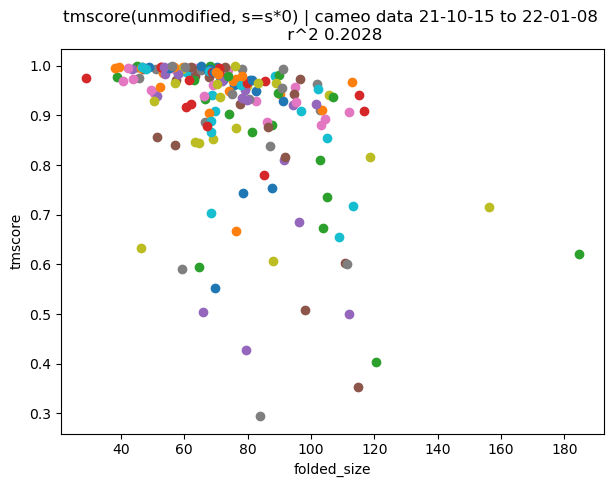

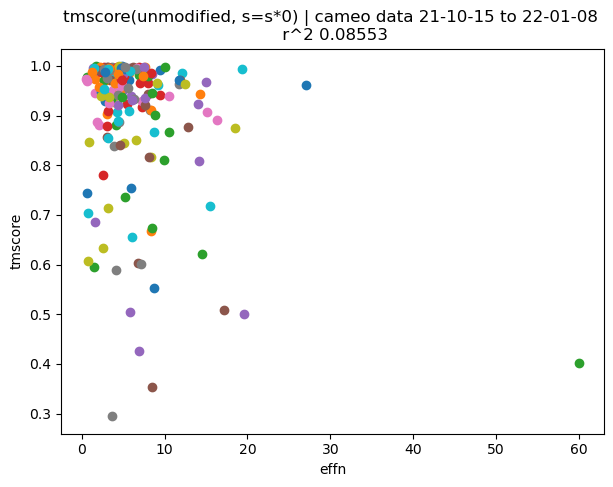

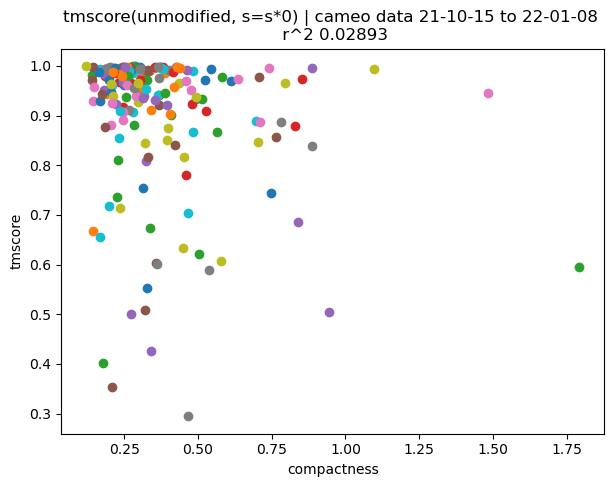

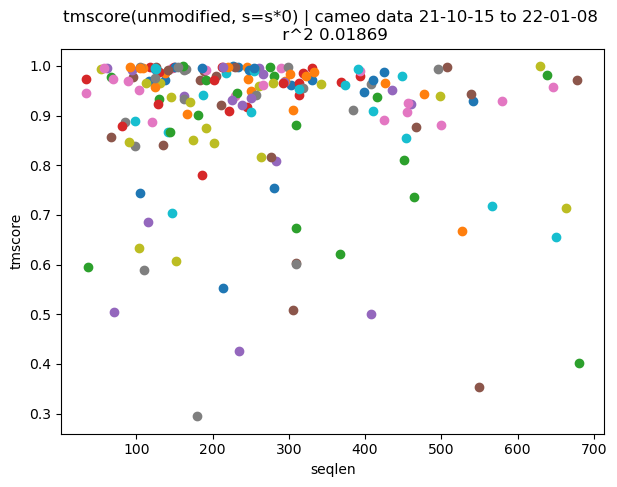

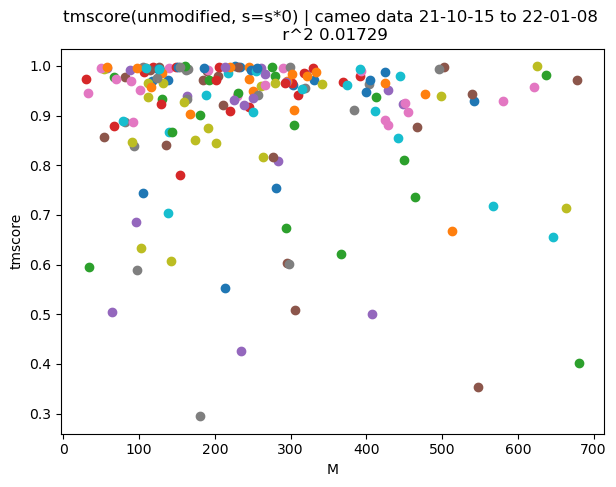

In [19]:
plt.rcParams['figure.figsize'] = [7, 5]
for stat in ['folded_size','effn', 'compactness','seqlen','M']:
    x=[]
    y=[]
    for protein in cameo_dict.keys():
        if not protein in exclude:
            plt.scatter(cameo_dict[protein][stat], cameo_dict[protein]['tmscore'])
            x.append(cameo_dict[protein][stat])
            y.append(cameo_dict[protein]['tmscore'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    plt.title('tmscore(unmodified, s=s*0) | cameo data 21-10-15 to 22-01-08 \n r^2 {:.4}'.format(r_value**2))
    plt.xlabel(stat)
    plt.ylabel('tmscore')
    plt.show()

In [20]:
# now use the model 4 run

In [25]:
# appendix

In [27]:
# check all pdbs in no mod prediction is in modded prediction
for pdb_file in os.listdir(CAMEO_PREDICTION_PATH):
    if not os.path.isfile(CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP + pdb_file):
        print('failed '+pdb_file)

failed 7tav_B_model_1_ptm_unrelaxed.pdb
failed 7t5f_B_model_1_ptm_relaxed.pdb
failed 7dq9_A_model_1_ptm_relaxed.pdb
failed 7bcz_A_model_1_ptm_unrelaxed.pdb
failed 7nx0_E_model_1_ptm_relaxed.pdb
failed 7p1v_A_model_1_ptm_relaxed.pdb
failed 7ls0_B_model_1_ptm_unrelaxed.pdb
failed 7vnb_A_model_1_ptm_unrelaxed.pdb
failed 7duv_A_model_1_ptm_unrelaxed.pdb
failed 7poh_B_model_1_ptm_relaxed.pdb
failed hmmstat.txt
failed 7poh_B_model_1_ptm_unrelaxed.pdb
failed 7lew_B_model_1_ptm_unrelaxed.pdb
failed 7tcb_B_model_1_ptm_relaxed.pdb
failed 7b26_C_model_1_ptm_unrelaxed.pdb
failed 7kua_A_model_1_ptm_unrelaxed.pdb
failed FORWARD_from_hmmfile.txt
failed 7djy_A_model_1_ptm_unrelaxed.pdb
failed 7spp_C_model_1_ptm_unrelaxed.pdb
failed 7dtp_A_model_1_ptm_unrelaxed.pdb
failed 7sh3_A_model_1_ptm_unrelaxed.pdb
failed 7t71_A_model_1_ptm_unrelaxed.pdb
failed 7v6p_A_model_1_ptm_unrelaxed.pdb
failed 7pqf_A_model_1_ptm_unrelaxed.pdb
failed 7t71_A_model_1_ptm_relaxed.pdb
failed 7w83_A_model_1_ptm_relaxed.pdb
faile

In [28]:
# check all pdbs in modded prediction is in no mod prediciton
for pdb_file in os.listdir(CAMEO_PREDICTION_PATH_ZEROED_SINGLE_REP):
    if not os.path.isfile(CAMEO_PREDICTION_PATH + pdb_file):
        print('failed '+pdb_file)

failed 7dnm_B_model_4_ptm_relaxed.pdb
failed 7b2o_A_model_4_ptm_relaxed.pdb
failed 7dvn_A_model_4_ptm_unrelaxed.pdb
failed 7mfi_A_model_4_ptm_unrelaxed.pdb
failed 7p1v_A_model_4_ptm_unrelaxed.pdb
failed 7amc_A_model_4_ptm_relaxed.pdb
failed 7mqy_A_model_4_ptm_relaxed.pdb
failed 7b1w_F_model_4_ptm_unrelaxed.pdb
failed 7vdy_A_model_4_ptm_relaxed.pdb
failed 7sy9_A_model_4_ptm_unrelaxed.pdb
failed 7s02_C_model_4_ptm_relaxed.pdb
failed 7m4n_A_model_4_ptm_unrelaxed.pdb
failed 7e3z_A_model_4_ptm_relaxed.pdb
failed 7sf6_A_model_4_ptm_unrelaxed.pdb
failed 7plq_B_model_4_ptm_relaxed.pdb
failed 7rds_A_model_4_ptm_relaxed.pdb
failed 7spo_C_model_4_ptm_relaxed.pdb
failed 7ab3_E_model_4_ptm_relaxed.pdb
failed 7s02_C_model_4_ptm_unrelaxed.pdb
failed 7bbz_A_model_4_ptm_relaxed.pdb
failed 7swk_B_model_4_ptm_relaxed.pdb
failed 7p3t_B_model_4_ptm_relaxed.pdb
failed 7b28_F_model_4_ptm_unrelaxed.pdb
failed 7obm_A_model_4_ptm_relaxed.pdb
failed 7dmf_A_model_4_ptm_unrelaxed.pdb
failed 7ofn_A_model_4_ptm_unre

In [29]:
# check hmmstat file that each prepended protein is the same as the given name
with open(CAMEO_PREDICTION_PATH + "hmmstat.txt") as f:
    lines = f.readlines()
for line in lines:
    parsed = line.split()
    if not parsed[0] == parsed[2][0:6]:
        print(parsed[0],parsed[2][0:6])

In [30]:
# check every fasta is a amino acid chain
# --- Not possible as these downloaded files do not contain that infomation. ---

In [31]:
# Check that the sequence at the top of each uniref... alignment file is the same sequence in the fasta file that was run.



In [32]:

# Is there a relationship between the pair rep and resulting tm score? maybe I could count number of times certain residues pop up?



In [33]:

# do analysis again for relaxed / unrelaxed
# --- nope. just focus on unrelaxed ---

In [34]:
# is there a relationship to physical width?

# yes

In [35]:
# check all proteins in cameo_dict matches with the proteins in sachin's alignment dir
sachin_alignment_proteins = ['6tf4_A','6wmk_A','6wqc_A','6xqj_A','6z01_A','7ab3_E','7amc_A','7ar0_B','7atr_A','7au7_A','7awk_A','7b0d_A','7b1k_B','7b1w_F','7b26_C','7b28_F','7b29_A','7b2a_A','7b2o_A','7b3a_A','7b4q_A','7b7t_A','7bbz_A','7bcb_B','7bcj_A','7bcz_A','7bew_A','7bhy_A','7bny_B','7cjs_B','7da9_A','7dah_E','7dck_A','7dcm_A','7dfe_A','7djy_A','7dk9_A','7dkk_A','7dko_A','7dmf_A','7dms_A','7dnm_B','7dnu_A','7don_B','7dq9_A','7dqg_A','7dru_C','7dsu_B','7dtp_A','7dut_A','7duv_A','7dvn_A','7e0m_A','7e2v_A','7e37_A','7e3z_A','7ee3_C','7eea_A','7ef6_A','7eft_B','7eqx_A','7eqx_C','7esx_A','7et8_A','7ezg_A','7f0h_A','7f17_B','7f6e_B','7f8a_A','7fbh_A','7fbp_B','7fe3_A','7fh3_A','7fip_A','7kdx_B','7kgc_A','7kik_A','7kiu_A','7kos_A','7kqv_D','7ksp_A','7kua_A','7kuw_A','7kzh_A','7l19_C','7l6j_A','7l6y_A','7lbu_A','7lc5_A','7lew_B','7ljh_A','7lnu_B','7ls0_B','7lvz_D','7lxc_A','7m0q_B','7m4m_A','7m4n_A','7mfi_A','7mfw_B','7mpz_A','7mqy_A','7mrk_D','7mro_A','7mrq_A','7mrs_B','7msj_A','7mu9_A','7ndr_A','7nf9_A','7nl4_A','7nmb_A','7nwz_D','7nx0_B','7nx0_E','7ny6_A','7o49_F','7o62_B','7obm_A','7ofn_A','7og0_B','7ool_A','7ouq_A','7p1b_C','7p1v_A','7p3b_B','7p3t_B','7p82_C','7pbk_A','7pkx_A','7plb_B','7plq_B','7poh_B','7ppp_A','7pq7_A','7pqf_A','7prd_A','7q03_A','7q1b_A','7q47_A','7r84_A','7rbw_A','7rds_A','7rdt_A','7re4_A','7re6_A','7rg7_A','7rrm_C','7rwk_A','7s02_C','7s13_C','7s13_L','7s6g_A','7s94_C','7sf6_A','7sh3_A','7siq_A','7sir_A','7spo_C','7spp_C','7swh_A','7swk_B','7sy9_A','7t24_A','7t5f_B','7t71_A','7t8o_B','7t9w_B','7tav_B','7tbs_A','7tcb_B','7v1v_A','7v5y_B','7v6p_A','7vdy_A','7vmu_A','7vnb_A','7vpf_A','7w83_A','7wbr_A']
for p in cameo_dict.keys():
    if p not in sachin_alignment_proteins:
        print(p)
for p in sachin_alignment_proteins:
    if p not in list(cameo_dict.keys()):
        print(p)

In [36]:
# appendix

In [37]:
maxtm = 0.99
print('REMOVE TMSCORE>', maxtm)
list_stats_r2 = {}
for stat in stats:
    x=[]
    y=[]
    for protein in cameo_dict.keys():
        if not protein in exclude:
            if not cameo_dict[protein]['tmscore']>maxtm: # here is the changed code to remove tmscore>0.9
                x.append(cameo_dict[protein][stat])
                y.append(cameo_dict[protein]['tmscore'])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    list_stats_r2[stat] = r_value**2

for w in sorted(list_stats_r2, key=list_stats_r2.get, reverse=True):
    print(w, list_stats_r2[w])

REMOVE TMSCORE> 0.99
folded_size 0.12587907803237608
effn 0.07327045564918226
no_code 0.04490102236903805
compactness 0.028888168009375857
extended 0.015832746112362805
Strand 0.015788369702036738
coil 0.01562448515700995
seqlen 0.005846016072653629
M 0.0051572497001472276
MSV1 0.004406164975885226
Isolatedbetabridgeresidue 0.003654083141373936
Alphahelix412 0.0035064350402062867
helix 0.002880164100079745
Pihelix 0.002656312539166452
FORWARD1 0.0016091172158062938
VITERBI1 0.0011387598746922234
relent 0.0010706771619725056
Turn 0.0009168982916058357
prelE 0.0007672789353201905
n 0.0005901384767837584
info 0.0005694577073477938
Bend 0.0002307509560600729
MSV2 0.0001907232651661609
VITERBI2 0.0001907232651661609
FORWARD2 0.0001907232651661609
helix310 0.00012662290902482293
compkl 3.9878108658098524e-05


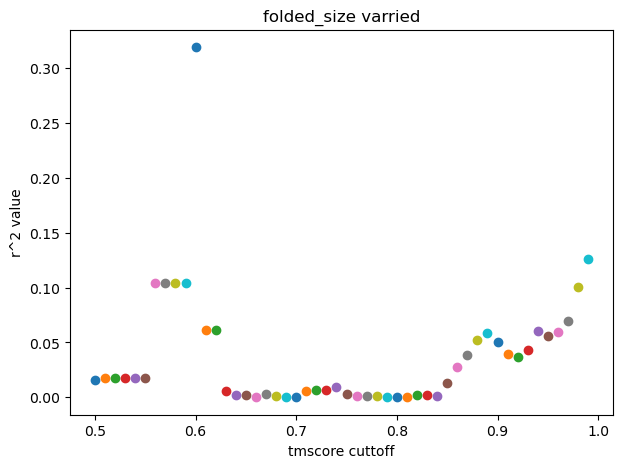

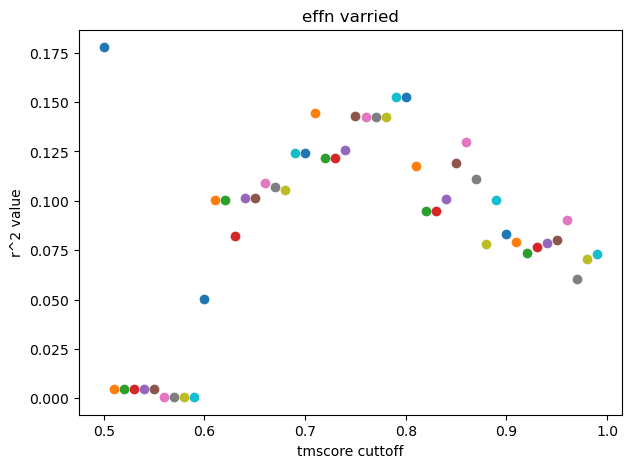

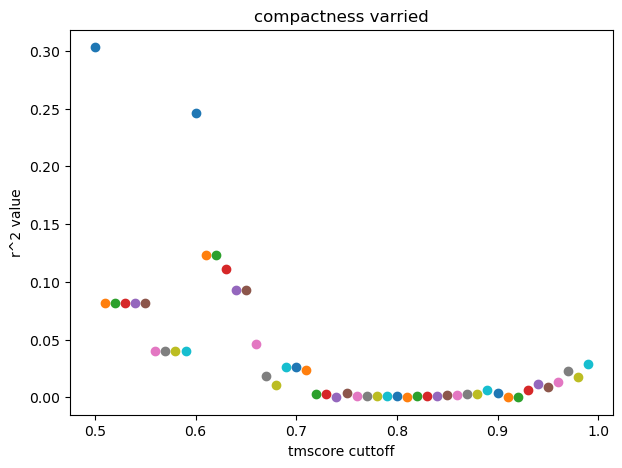

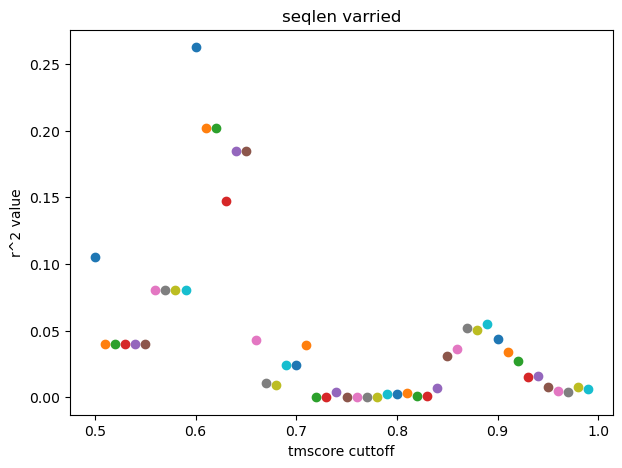

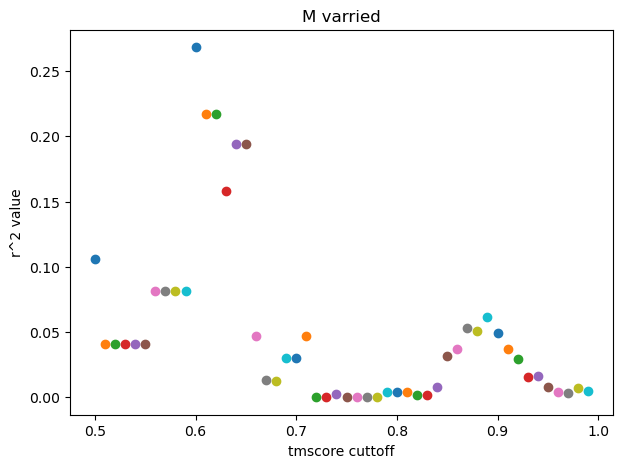

In [38]:
for stat in ['folded_size','effn', 'compactness','seqlen','M']:
    for maxscore in range(50,100):
        maxscore = maxscore*0.01
        x=[]
        y=[]
        for protein in cameo_dict.keys():
            if not cameo_dict[protein]['tmscore']>maxscore:
                x.append(cameo_dict[protein][stat])
                y.append(cameo_dict[protein]['tmscore'])
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        plt.scatter(maxscore,r_value**2)
        plt.title(stat + ' varried')
        plt.xlabel('tmscore cuttoff')
        plt.ylabel('r^2 value')
    plt.show()
